In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  
datadir="/export/data/dataset/media/"

In [5]:
import glob
import random
import os
import numpy as np
import time
import datetime
import sys

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch
# from visdom import Visdom

import itertools
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
img_size=256
food1 = "curry"
food2 = "rice"
fooddir = "foodimg"+str(img_size)+"/"

epochs = 5
batch_size= 3

outdir='out/cycle'
os.makedirs(outdir, exist_ok=True)
outdirA='out/cycle/A'
os.makedirs(outdirA, exist_ok=True)
outdirB='out/cycle/B'
os.makedirs(outdirB, exist_ok=True)

In [4]:
# ドメインAとドメインBの画像データセット生成クラス
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(datadir+fooddir+food1+'/img*.jpg'))
        self.files_B = sorted(glob.glob(datadir+fooddir+food2+'/img*.jpg'))
        
        print(len(self.files_A))
#        print(fooddir+food1+'/img*.jpg')
        
    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [5]:
# ResidualBlockの定義
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.conv_block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.conv_block(x)

In [6]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),

            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256),

            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, padding=1),
            nn.InstanceNorm2d(512), 
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        x =  self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

In [8]:
# 過去の生成データ(50iter分)を保持しておく
class ReplayBuffer():
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            #
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))


In [9]:
class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

# 学習

In [10]:
class Opts():
    def __init__(self):
        self.start_epoch = 0
        self.n_epochs = epochs
        self.batch_size = batch_size
        self.dataroot = ''
        self.lr = 0.0002
        self.decay_epoch = 200
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cpu = False
        self.n_cpu = 8
        self.device_name = "cuda:0"
        self.device = torch.device(self.device_name)
        self.load_weight = False

opt = Opts()


In [11]:

# 生成器
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)

# 識別器
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

# GPU
if not opt.cpu:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

# 重みパラメータ初期化
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# 保存したモデルのロード
if opt.load_weight is True:
    netG_A2B.load_state_dict(torch.load(outdir+"/netG_A2B.pth", map_location="cuda:0"), strict=False)
    netG_B2A.load_state_dict(torch.load(outdir+"/netG_B2A.pth", map_location="cuda:0"), strict=False)
    netD_A.load_state_dict(torch.load(outdir+"/netD_A.pth", map_location="cuda:0"), strict=False)
    netD_B.load_state_dict(torch.load(outdir+"/netD_B.pth", map_location="cuda:0"), strict=False)

# 損失関数
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.start_epoch, opt.decay_epoch).step)

# 入出力メモリ確保
Tensor = torch.cuda.FloatTensor if not opt.cpu else torch.Tensor
input_A = Tensor(opt.batch_size, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batch_size, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batch_size).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batch_size).fill_(0.0), requires_grad=False)

# 過去データ分のメモリ確保
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# データローダー
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=opt.batch_size, shuffle=True, num_workers=opt.n_cpu)

print("num dataloader= {}".format(len(dataloader)))

/tmp/ipykernel_2653633/419819251.py:13: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  torch.nn.init.normal(m.weight.data, 0.0, 0.02)


1000
num dataloader= 334


In [12]:
import torchsummary
torchsummary.summary(netG_A2B, (opt.input_nc, opt.size, opt.size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1          [-1, 3, 262, 262]               0
            Conv2d-2         [-1, 64, 256, 256]           9,472
    InstanceNorm2d-3         [-1, 64, 256, 256]               0
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-6        [-1, 128, 128, 128]               0
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8          [-1, 256, 64, 64]         295,168
    InstanceNorm2d-9          [-1, 256, 64, 64]               0
             ReLU-10          [-1, 256, 64, 64]               0
  ReflectionPad2d-11          [-1, 256, 66, 66]               0
           Conv2d-12          [-1, 256, 64, 64]         590,080
   InstanceNorm2d-13          [-1, 256, 64, 64]               0
             ReLU-14          [-1, 256,

In [13]:
def save_loss(train_info, batches_done):
    """
    lossの保存
    """
    for k, v in train_info.items():
        writer.add_scalar(k, v, batches_done)


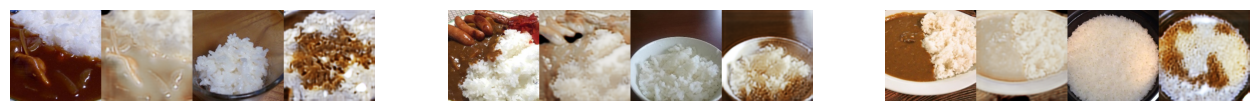

Epoch[4](330/334) loss_G: 6.1162 loss_G_identity: 1.7752 loss_G_GAN: 1.0655 loss_G_cycle: 3.2755 loss_D: 0.2541 Time: 1402.8043 sec 
Epoch[4](331/334) loss_G: 5.3861 loss_G_identity: 1.1686 loss_G_GAN: 1.4941 loss_G_cycle: 2.7234 loss_D: 0.1461 Time: 1403.4258 sec 
Epoch[4](332/334) loss_G: 4.9626 loss_G_identity: 1.3979 loss_G_GAN: 0.8103 loss_G_cycle: 2.7543 loss_D: 0.2125 Time: 1404.2315 sec 
Epoch[4](333/334) loss_G: 6.6819 loss_G_identity: 2.1179 loss_G_GAN: 1.2186 loss_G_cycle: 3.3454 loss_D: 0.2625 Time: 1405.0378 sec 


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
start = time.time()
for epoch in range(opt.start_epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):
        # モデルの入力
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ##### 生成器A2B、B2Aの処理 #####
        optimizer_G.zero_grad()

        # 同一性損失の計算（Identity loss)
        # G_A2B(B)はBと一致
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A)はAと一致
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # 敵対的損失（GAN loss）
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # サイクル一貫性損失（Cycle-consistency loss）
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # 生成器の合計損失関数（Total loss）
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()

        ##### ドメインAの識別器 #####
        optimizer_D_A.zero_grad()

        # ドメインAの本物画像の識別結果（Real loss）
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # ドメインAの生成画像の識別結果（Fake loss）
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # 識別器（ドメインA）の合計損失（Total loss）
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()

        ##### ドメインBの識別器 #####
        optimizer_D_B.zero_grad()

        # ドメインBの本物画像の識別結果（Real loss）
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # ドメインBの生成画像の識別結果（Fake loss）
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # 識別器（ドメインB）の合計損失（Total loss）
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        if i % 5 ==0:
            output_image = torch.cat([real_A, fake_B, real_B, fake_A], dim=3)
            r,c=1,3
            output_image=output_image.cpu().detach().numpy()
            fig, axs = plt.subplots(r, c, figsize=(16,4), squeeze=False)
            cnt = 0      
            for k in range(r):
              for j in range(c):
                   axs[k,j].imshow((output_image[cnt].transpose(1,2,0)+1)/2.0,vmin=0,vmax=1.0)
                   axs[k,j].axis('off')
                   cnt += 1
                
            display.clear_output(wait = True)
            display.display(fig)
            plt.close()
        
        
        if i % 1 == 0:
            tm = time.time() - start
            print('Epoch[{}]({}/{}) loss_G: {:.4f} loss_G_identity: {:.4f} loss_G_GAN: {:.4f} loss_G_cycle: {:.4f} loss_D: {:.4f} Time: {:.4f} sec '.format(
                epoch, i, len(dataloader), loss_G, (loss_identity_A + loss_identity_B),
                (loss_GAN_A2B + loss_GAN_B2A), (loss_cycle_ABA + loss_cycle_BAB), (loss_D_A + loss_D_B), tm
                ))

        train_info = {
            'epoch': epoch, 
            'batch_num': i, 
            'lossG': loss_G.item(),
            'lossG_identity': (loss_identity_A.item() + loss_identity_B.item()),
            'lossG_GAN': (loss_GAN_A2B.item() + loss_GAN_B2A.item()),
            'lossG_cycle': (loss_cycle_ABA.item() + loss_cycle_BAB.item()),
            'lossD': (loss_D_A.item() + loss_D_B.item()), 
            }

        batches_done = (epoch - 1) * len(dataloader) + i
        #save_loss(train_info, batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), outdir+'/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), outdir+'/netG_B2A.pth')
    torch.save(netD_A.state_dict(), outdir+'/netD_A.pth')
    torch.save(netD_B.state_dict(), outdir+'/netD_B.pth')

In [15]:

class Opts_test():
    def __init__(self):
        self.batch_size = 1
        self.dataroot = ''
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cpu = False
        self.n_cpu = 8
        self.device_name = "cuda:0"
        self.device = torch.device(self.device_name)
        self.load_weight = False
        self.generator_A2B = outdir+'/netG_A2B.pth'
        self.generator_B2A = outdir+'/netG_B2A.pth'
        self.cuda = True

opt2 = Opts_test()


In [16]:

# 生成器G
netG_A2B = Generator(opt2.input_nc, opt2.output_nc)
netG_B2A = Generator(opt2.output_nc, opt2.input_nc)

# CUDA
if opt2.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load(opt2.generator_A2B))
netG_B2A.load_state_dict(torch.load(opt2.generator_B2A))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt2.cuda else torch.Tensor
input_A = Tensor(opt2.batch_size, opt2.input_nc, opt2.size, opt2.size)
input_B = Tensor(opt2.batch_size, opt2.output_nc, opt2.size, opt2.size)

# Dataset loader
transforms_ = [transforms.Resize(int(opt2.size*1.0), Image.BICUBIC), 
                transforms.RandomCrop(opt2.size), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt2.dataroot, transforms_=transforms_, mode='train'), 
                        batch_size=opt2.batch_size, shuffle=False, num_workers=opt2.n_cpu)


1000


In [17]:
##### 生成器Gによる画像生成　#####
from torchvision.utils import save_image

num_create = 100

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    out_img1 = torch.cat([real_A, fake_B], dim=2)
    out_img2 = torch.cat([real_B, fake_A], dim=2)

    # Save image files
    save_image(out_img1, outdir+'/A/%04d.png' % (i+1))
    save_image(out_img2, outdir+'/B/%04d.png' % (i+1))

    if i > num_create:
        break


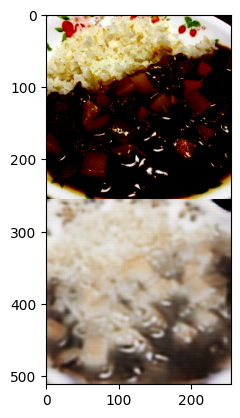

In [17]:
# A->Bの生成画像
import matplotlib.pyplot as plt
img = plt.imread(outdir+'/A/0003.png')
plt.imshow(img)